# Generating SBM-Environment Dataset

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from sbm_environment import generate_sbm_graph_list

In [2]:
sbmg = generate_sbm_graph_list(n_samples=1)[0]
graph_data, domain_id = sbmg.get()
print(graph_data)
print(domain_id)
print(sbmg.stat())

Total generation time: 0.78 secs.                 
{'x': tensor([5, 7, 1, 5, 4, 4, 0, 2, 6, 0, 0, 3, 7, 2, 5, 1, 4, 4, 4, 1, 1, 5, 1, 4,
        1, 4, 1, 1, 2, 4, 4, 3, 7, 6, 6, 1, 6, 4, 6, 3, 5, 1, 2, 7, 0, 6, 7, 7,
        0, 2, 0, 6, 7, 5, 6, 0, 5, 7, 3, 7, 4, 3, 2, 1, 3, 2, 1, 7, 7, 5, 5, 1,
        7, 1, 0, 7, 1, 7, 7, 7, 6, 5, 6, 6, 0, 6, 6, 6, 7, 3, 4, 5, 1, 4, 3, 4,
        4, 7, 0, 0, 7, 1, 7, 2, 0, 2, 3, 5, 0, 4, 1, 5, 0, 0, 6, 7, 2, 6, 4, 2,
        4, 5, 0, 2, 3, 0, 1, 4, 6, 3, 3, 1, 6, 0, 0]), 'y': tensor(1), 'edge_index': tensor([[  0,   0,   0,  ..., 134, 134, 134],
        [  2,   9,  10,  ..., 108, 116, 126]])}
2
{'# of nodes': 135, '# of edges': 1857, 'avg degree': 13.755555555555556}


In [3]:
sbm_graph_list = generate_sbm_graph_list(n_samples=60000, n_processes=8)

Total generation time: 505.20 secs.               


Labels: min: 0, max: 2


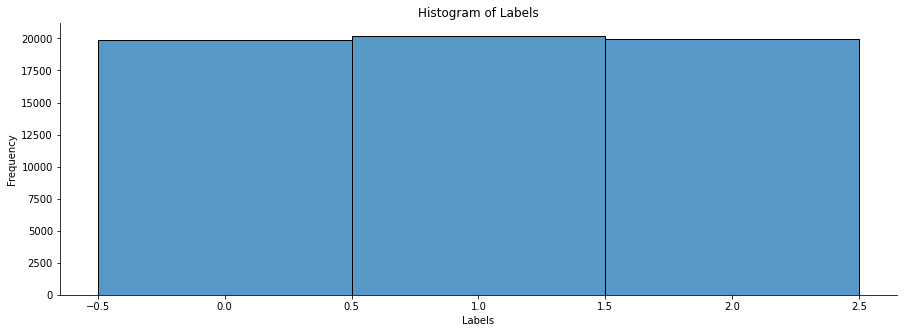

Doamin Ids: min: 0, max: 3


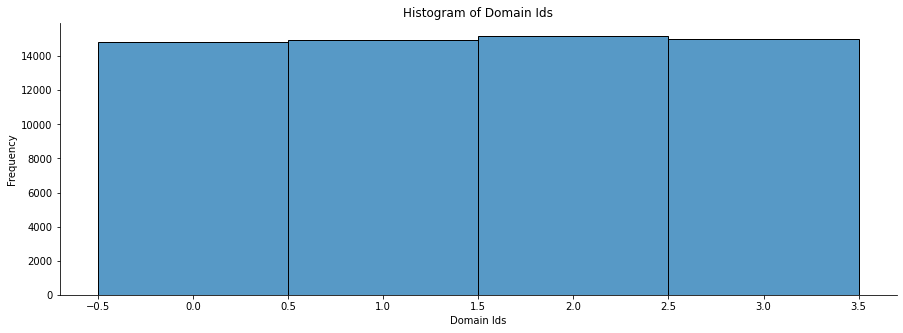

Graph sizes: min: 103, max: 192


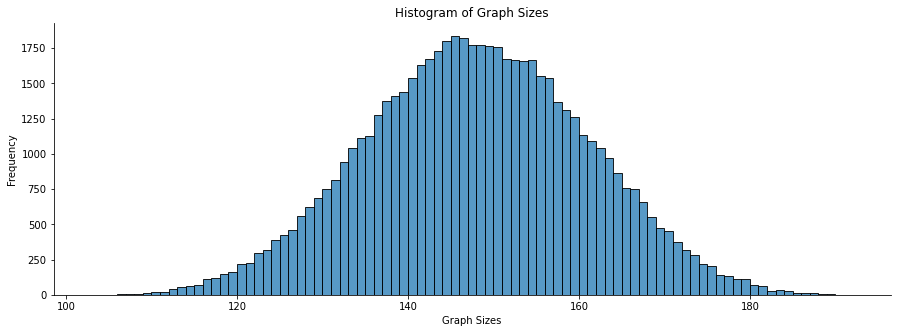

In [4]:
label_list = [int(sbmg.get()[0]['y']) for sbmg in sbm_graph_list]
domain_id_list = [int(sbmg.get()[1]) for sbmg in sbm_graph_list]
graph_size_list = [int(sbmg.stat()['# of nodes']) for sbmg in sbm_graph_list]


print(f'Labels: min: {min(label_list)}, max: {max(label_list)}')
f, ax = plt.subplots(figsize=(15, 5))
sns.despine(f)
sns.histplot(label_list, binwidth=1, binrange=(-0.5, 2.5))
ax.set_xlabel('Labels')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Labels')
plt.show()

print(f'Doamin Ids: min: {min(domain_id_list)}, max: {max(domain_id_list)}')
f, ax = plt.subplots(figsize=(15, 5))
sns.despine(f)
sns.histplot(domain_id_list, binwidth=1, binrange=(-0.5, 3.5))
ax.set_xlabel('Domain Ids')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Domain Ids')
plt.show()

print(f'Graph sizes: min: {min(graph_size_list)}, max: {max(graph_size_list)}')
f, ax = plt.subplots(figsize=(15, 5))
sns.despine(f)
sns.histplot(graph_size_list, binwidth=1)
ax.set_xlabel('Graph Sizes')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Graph Sizes')
plt.show()

In [5]:
torch.save([sbmg.get()[0] for sbmg in sbm_graph_list], 'SBM-Environment.pt')
np.save('SBM-Environment_group.npy', np.array([sbmg.get()[1] for sbmg in sbm_graph_list]))